In [15]:
import tensorflow as tf
from dec_model import DECModel, dec_loss, train_dec_model  # Ensure that the DECModel class is available in the notebook's environment

In [7]:
loaded_model = tf.keras.models.load_model('../../dec_model', custom_objects={'DECModel': DECModel})
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(), loss_fn=dec_loss)  # Specify the optimizer and loss_fn

TypeError: compile() missing 1 required positional argument: 'loss_fn'

In [20]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

def load_and_preprocess_data():

    np.random.seed(42)
    idx = pd.IndexSlice

    meta = pd.read_hdf('/home/groovyjac/projects/autonomous-portfolio-management/main_data_store_JDKv1.h5',
                        'stocks/base_fundamentals')

    selected_features = [
        'Sector', 'GicSector', 'MarketCapitalization', 'DividendYield', 'PERatio',
        'Beta', 'Industry', 'GicGroup', 'GicIndustry', 'GicSubIndustry', 'BookValue',
        'EBITDA', 'RevenueTTM', 'GrossProfitTTM', 'OperatingMarginTTM', 'ReturnOnAssetsTTM',
        'ReturnOnEquityTTM', 'PriceSalesTTM', 'PriceBookMRQ', 'EnterpriseValue',
        'EnterpriseValueRevenue', 'EnterpriseValueEbitda', 'SharesOutstanding',
        'PercentInstitutions', 'PayoutRatio', '52WeekHigh', '52WeekLow', '50DayMA',
        '200DayMA', 'ForwardPE', 'SharesFloat', 'PercentInsiders',
        'ShortPercent', 'ForwardAnnualDividendRate', 'ForwardAnnualDividendYield',
        'TrailingPE', 'PriceEarningsRatio', 'DividendShare', 'EarningsShare',
        'EPSEstimateCurrentYear', 'EPSEstimateNextYear', 'EPSEstimateNextQuarter',
        'EPSEstimateCurrentQuarter', 'ProfitMargin',
        'QuarterlyRevenueGrowthYOY', 'DilutedEpsTTM', 'QuarterlyEarningsGrowthYOY'
    ]
   

    df = pd.DataFrame(meta.loc[idx[:, :, selected_features]])
    df = df.droplevel(1)[~df.droplevel(1).index.duplicated(keep='first')]
    df = df.unstack(level=1)
    df.columns = df.columns.droplevel(0)
    df = df.drop(['Sector', 'GicSector', 'Industry', 'GicGroup', 'GicIndustry', 'GicSubIndustry'], axis=1)
    df = df.astype('float64')
    
    # Check for missing values
    print(df.isna().sum())
    
    # Fill in missing values with KNN imputation
    imputer = KNNImputer(n_neighbors=5)
    df_imputed = imputer.fit_transform(df)
    df = pd.DataFrame(df_imputed, columns=df.columns, index=df.index)
    
    # EDA plots
    # sns.set(style='whitegrid', palette='muted')
    # df.hist(figsize=(20, 20), layout=(11, 4))
    # plt.tight_layout()
    # plt.show()
    
    # sns.pairplot(df.sample(1000, replace=True))
    # plt.show()
    
    # plt.figure(figsize=(20, 20))
    # sns.boxplot(data=df)
    # plt.xticks(rotation=90)
    # plt.show()
    
    # corr = df.corr()
    # plt.figure(figsize=(20, 20))
    # sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    # plt.show()
    
    # Feature selection for DEC - Use all features for now, as feature selection for DEC is problem-specific
    selected_features_final = df.columns

    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[selected_features_final])

    return scaled_data, df, selected_features_final

In [21]:
scaled_data, df, selected_features_final = load_and_preprocess_data()

MarketCapitalization           1
DividendYield                  1
PERatio                       40
Beta                           4
BookValue                      2
EBITDA                        30
RevenueTTM                     0
GrossProfitTTM                 0
OperatingMarginTTM             0
ReturnOnAssetsTTM              0
ReturnOnEquityTTM              0
PriceSalesTTM                  0
PriceBookMRQ                   0
EnterpriseValue                0
EnterpriseValueRevenue         0
EnterpriseValueEbitda          0
SharesOutstanding              0
PercentInstitutions            0
PayoutRatio                    0
52WeekHigh                     0
52WeekLow                      0
50DayMA                        0
200DayMA                       0
ForwardPE                      0
SharesFloat                    0
PercentInsiders                0
ShortPercent                   0
ForwardAnnualDividendRate      0
ForwardAnnualDividendYield     0
TrailingPE                     0
DividendSh

In [22]:
len(scaled_data[0])

40

In [23]:
import numpy as np
import tensorflow as tf

# Load your dataset (assuming it is in the correct format)
# X is the feature matrix with shape (503, number_of_features)
X = scaled_data # Your data here

# If you need to reshape the data, you can use the following line:
X = np.reshape(X, (503, 40))

# Specify the number of clusters
n_clusters = 3

# Create an instance of the DECModel
model = DECModel(n_clusters=n_clusters, input_shape=X.shape[1])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Use the learning_rate argument instead of deprecated lr
model.compile(optimizer=optimizer, loss_fn=dec_loss)

# Create a TensorFlow Dataset from your NumPy array
dataset = tf.data.Dataset.from_tensor_slices(X)

# Set the batch size (adjust as needed)
batch_size = 32

# Batch the dataset
dataset = dataset.batch(batch_size)

# Train the model on your dataset (you can set n_epochs and early_stopping_patience as needed)
n_epochs = 50
early_stopping_patience = 10
# Train the model on the batched dataset
train_dec_model(model, dataset, n_epochs, early_stopping_patience)

# Obtain cluster assignments for each data point
q = model.cluster_layer(X)
cluster_assignments = tf.argmax(q, axis=1).numpy()

# Perform cluster analysis using the obtained cluster_assignments

2023-04-05 15:44:56.894456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [503,40]
	 [[{{node Placeholder/_0}}]]


Loss shape: ()
Loss content: 1.7353275
Epoch 1: Loss 1.735
Loss shape: ()
Loss content: 1.6668512
Epoch 2: Loss 1.667
Loss shape: ()
Loss content: 1.5864794
Epoch 3: Loss 1.586
Loss shape: ()
Loss content: 1.5413398
Epoch 4: Loss 1.541
Loss shape: ()
Loss content: 1.4387336
Epoch 5: Loss 1.439
Loss shape: ()
Loss content: 1.348194
Epoch 6: Loss 1.348
Loss shape: ()
Loss content: 1.0413483
Epoch 7: Loss 1.041
Loss shape: ()
Loss content: 0.89443284
Epoch 8: Loss 0.894
Loss shape: ()
Loss content: 1.5060989
Epoch 9: Loss 1.506
Loss shape: ()
Loss content: 1.393051
Epoch 10: Loss 1.393
Loss shape: ()
Loss content: 0.9966446
Epoch 11: Loss 0.997
Loss shape: ()
Loss content: 0.7468731
Epoch 12: Loss 0.747
Loss shape: ()
Loss content: 1.1963702
Epoch 13: Loss 1.196
Loss shape: ()
Loss content: 1.0172186
Epoch 14: Loss 1.017
Loss shape: ()
Loss content: 0.39158317
Epoch 15: Loss 0.392
Loss shape: ()
Loss content: 1.4307035
Epoch 16: Loss 1.431
Loss shape: ()
Loss content: 1.2895517
Epoch 17: 

In [32]:
cluster_assignments
results_df = pd.DataFrame(scaled_data, columns=selected_features_final, index=df.index)

In [33]:
len(results_df)

503

In [36]:
results_df['label'] = cluster_assignments

In [40]:
results_df['label'].sort_values().unique()

array([0, 1, 2, 4, 5, 6, 7, 8, 9])

In [45]:
results_df.columns

Index(['MarketCapitalization', 'DividendYield', 'PERatio', 'Beta', 'BookValue',
       'EBITDA', 'RevenueTTM', 'GrossProfitTTM', 'OperatingMarginTTM',
       'ReturnOnAssetsTTM', 'ReturnOnEquityTTM', 'PriceSalesTTM',
       'PriceBookMRQ', 'EnterpriseValue', 'EnterpriseValueRevenue',
       'EnterpriseValueEbitda', 'SharesOutstanding', 'PercentInstitutions',
       'PayoutRatio', '52WeekHigh', '52WeekLow', '50DayMA', '200DayMA',
       'ForwardPE', 'SharesFloat', 'PercentInsiders', 'ShortPercent',
       'ForwardAnnualDividendRate', 'ForwardAnnualDividendYield', 'TrailingPE',
       'DividendShare', 'EarningsShare', 'EPSEstimateCurrentYear',
       'EPSEstimateNextYear', 'EPSEstimateNextQuarter',
       'EPSEstimateCurrentQuarter', 'ProfitMargin',
       'QuarterlyRevenueGrowthYOY', 'DilutedEpsTTM',
       'QuarterlyEarningsGrowthYOY', 'label'],
      dtype='object')

In [48]:
unscaled_results_df = df
unscaled_results_df['label'] = results_df['label'] = cluster_assignments

In [49]:
unscaled_results_df.columns

Index(['MarketCapitalization', 'DividendYield', 'PERatio', 'Beta', 'BookValue',
       'EBITDA', 'RevenueTTM', 'GrossProfitTTM', 'OperatingMarginTTM',
       'ReturnOnAssetsTTM', 'ReturnOnEquityTTM', 'PriceSalesTTM',
       'PriceBookMRQ', 'EnterpriseValue', 'EnterpriseValueRevenue',
       'EnterpriseValueEbitda', 'SharesOutstanding', 'PercentInstitutions',
       'PayoutRatio', '52WeekHigh', '52WeekLow', '50DayMA', '200DayMA',
       'ForwardPE', 'SharesFloat', 'PercentInsiders', 'ShortPercent',
       'ForwardAnnualDividendRate', 'ForwardAnnualDividendYield', 'TrailingPE',
       'DividendShare', 'EarningsShare', 'EPSEstimateCurrentYear',
       'EPSEstimateNextYear', 'EPSEstimateNextQuarter',
       'EPSEstimateCurrentQuarter', 'ProfitMargin',
       'QuarterlyRevenueGrowthYOY', 'DilutedEpsTTM',
       'QuarterlyEarningsGrowthYOY', 'label'],
      dtype='object')

In [57]:
# Group the dataframe by the 'label' column (cluster labels)
cluster_groups = unscaled_results_df[['MarketCapitalization', 'PERatio', 'Beta', 'EBITDA', 'ForwardPE', '52WeekHigh', '52WeekLow', '50DayMA', '200DayMA', 'TrailingPE', 'EPSEstimateCurrentYear',
                                      'EPSEstimateNextYear', 'EPSEstimateNextQuarter', 'EPSEstimateCurrentQuarter', 'ProfitMargin', 'QuarterlyRevenueGrowthYOY', 'DilutedEpsTTM',
                                      'QuarterlyEarningsGrowthYOY', 'label']].groupby('label')

# Define the desired cluster labels
desired_clusters = [5, 9]

# Loop through each cluster group and print summary statistics only for desired clusters
for cluster_label, cluster_df in cluster_groups:
    if cluster_label in desired_clusters:
        print("Summary statistics for cluster:", cluster_label)
        print(cluster_df.describe())
        print("-" * 80)  # Separator line

Summary statistics for cluster: 5
       MarketCapitalization     PERatio        Beta        EBITDA   ForwardPE  \
count          3.020000e+02  302.000000  302.000000  3.020000e+02  302.000000   
mean           3.085847e+10   26.414486    1.075162  3.176682e+09   17.869482   
std            2.924407e+10   24.149352    0.431137  3.085973e+09   12.187028   
min            2.593367e+09    1.717400    0.166600 -2.413000e+09    0.000000   
25%            1.332355e+10   14.006600    0.781900  1.353303e+09   11.699325   
50%            2.086487e+10   20.269050    1.076450  2.130100e+09   16.299900   
75%            3.697711e+10   30.602900    1.317225  3.866931e+09   20.898700   
max            1.829185e+11  250.550000    2.895800  2.127300e+10  116.279100   

       52WeekHigh   52WeekLow     50DayMA    200DayMA  TrailingPE  \
count  302.000000  302.000000  302.000000  302.000000  302.000000   
mean   115.818622   72.205620   93.457698   91.310786   23.260049   
std     91.340361   55.530564

In [56]:
# Count the number of occurrences of each cluster label in the 'label' column
cluster_counts = unscaled_results_df['label'].value_counts()
cluster_counts

5    302
9    185
1      3
4      3
0      3
6      2
8      2
2      2
7      1
Name: label, dtype: int64

In [ ]:
from scipy.stats import kruskal

# Perform Kruskal-Wallis test on MarketCapitalization across clusters
clusters = results_df['label'].unique()
data = [results_df[results_df['label'] == cluster]['MarketCapitalization'] for cluster in clusters]
h_stat, p_value = kruskal(*data)

# Determine if the p-value is significant at a 0.05 significance level
if p_value < 0.05:
    print("The clusters have significantly different MarketCapitalization (p-value:", p_value, ")")
else:
    print("The clusters do not have significantly different MarketCapitalization (p-value:", p_value, ")")

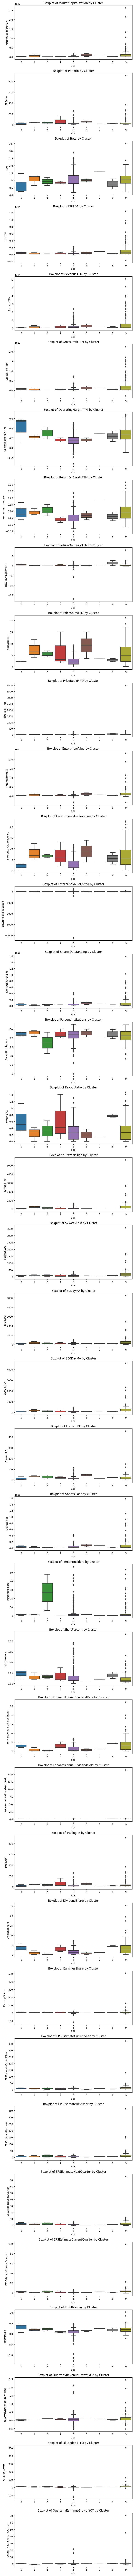

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume 'df' is your DataFrame containing the features and the 'label' column
bad_list= ['DividendYield', 'BookValue']
# List of features to plot
features = ['MarketCapitalization', 'PERatio', 'Beta', 'EBITDA', 'RevenueTTM',
             'GrossProfitTTM', 'OperatingMarginTTM', 'ReturnOnAssetsTTM', 'ReturnOnEquityTTM', 'PriceSalesTTM',
       'PriceBookMRQ', 'EnterpriseValue', 'EnterpriseValueRevenue',
       'EnterpriseValueEbitda', 'SharesOutstanding', 'PercentInstitutions','PayoutRatio', '52WeekHigh', '52WeekLow', '50DayMA', '200DayMA',
       'ForwardPE', 'SharesFloat', 'PercentInsiders', 'ShortPercent',
       'ForwardAnnualDividendRate', 'ForwardAnnualDividendYield', 'TrailingPE',
       'DividendShare', 'EarningsShare', 'EPSEstimateCurrentYear',
       'EPSEstimateNextYear', 'EPSEstimateNextQuarter',
       'EPSEstimateCurrentQuarter', 'ProfitMargin',
       'QuarterlyRevenueGrowthYOY', 'DilutedEpsTTM',
       'QuarterlyEarningsGrowthYOY']  # Add more features if needed

# Create subplots for each feature
fig, axes = plt.subplots(len(features), 1, figsize=(8, 4 * len(features)))

# Iterate over each feature and create a boxplot
for i, feature in enumerate(features):
    sns.boxplot(x='label', y=feature, data=unscaled_results_df, ax=axes[i])
    axes[i].set_title(f"Boxplot of {feature} by Cluster")

plt.tight_layout()
plt.show()